<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №1</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили:
- Клименко К.В.
- Бадагов А.В.

Проверил: Осипенко И.В.

<center>  Новосибирск, 2025  </center>

# Цель работ

Получить практические навыки работы по решению задачи первичного анализа «сырых» данных, подготовки массива к обработке, выявлению и описанию зависимостей в исходных данных с использованием языка программирования Python.

# Ход работы

In [ ]:
# Проверка версии и пути к выбранному интерпретатору
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Путь к интерпретатору Python - /usr/bin/python3


In [ ]:
# Python 3.10
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns

Для загрузки табличных данных из файла применим функцию .read_csv() с указанием параметров: путь к файлу csv, разделитель для колонок - символ табуляции, в качестве десятичного разделителя запятая, индекс заголовка 0, а неизвестные значения у нас были равны 'isntKnown'.

In [ ]:
df = pd.read_csv("./diamonds_nan_24.csv",
        sep='\t',
        decimal=',',
        header=0,
        na_values=['isntKnown']
    )

##  Первичный анализ исходных данных

Далее мы вывели на экран список колонок, затем форму матрицы датафрейма, а также количество null значений для каждого столбца. По итогам вывода, в нашем исходном датафрейме 11 признаков: 'ID', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price','x', 'y', 'z' и 53940 записей.

In [ ]:
print(list(df.columns), "\n")
print(df.shape, "\n")
print(df.isna().sum(), "\n")

['ID', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z'] 

(53940, 11) 

ID         22
carat      22
cut        23
color      21
clarity    22
depth      22
table      31
price      24
x          16
y          26
z          22
dtype: int64 



В датафрейме представлены характеристики алмазов, используемые для предсказания цены (price): carat — масса в каратах; cut — качество огранки; color — цвет по шкале от D (бесцветный) до Z; clarity — чистота (наличие дефектов); depth —  это высота алмаза от его верхней части (таблицы) до нижней точки (культа) в процентах от диаметра; table — самая большая плоская грань в верхней части алмаза в процентах от диаметра; x, y, z — физические размеры в миллиметрах. Признак ID — это просто уникальный номер записи, не содержащий полезной информации о свойствах алмаза, поэтому он удаляется с помощью df = df.drop(labels=['ID'], axis=1), чтобы не мешать обучению модели.

In [ ]:
df = df.drop(
        labels=['ID'],
        axis=1
    )

Для визуального анализа распределения пропущенных (NULL) значений в исходном DataFrame была реализована функция plotNullTable. Эта функция генерирует графическое представление маски пропусков: каждая ячейка таблицы соответствует одному элементу исходного датафрейма, при этом белым цветом обозначаются пропущенные значения, а синим — присутствующие данные.

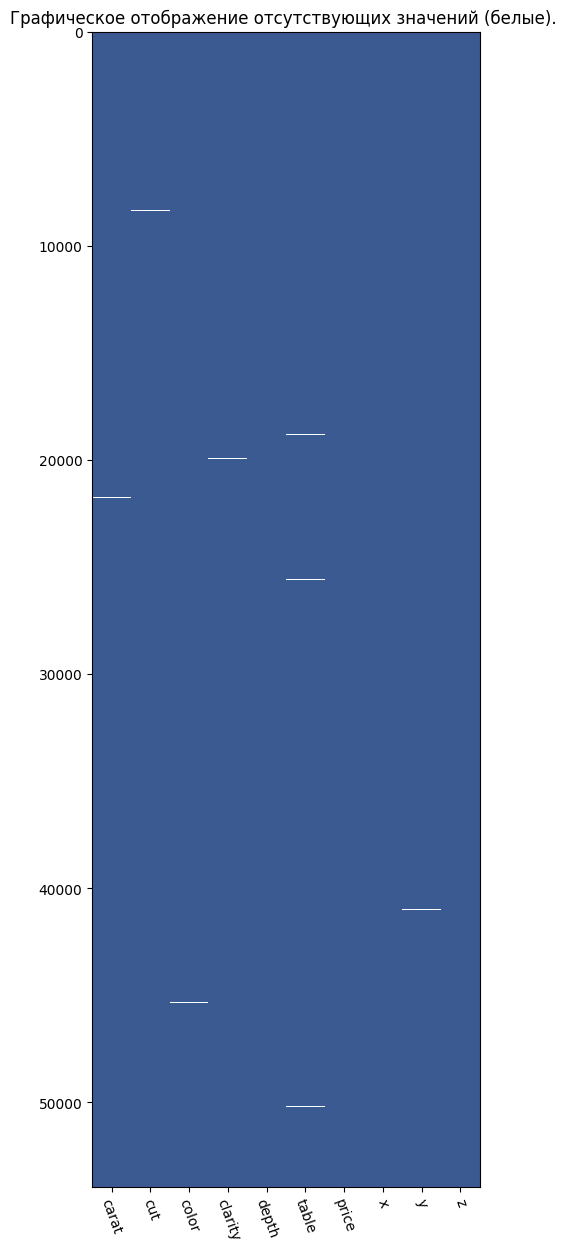

In [ ]:
def plotNullTable(data_f, add_to_title =""):
    if   len(data_f.columns)> 20:
        k = 3
    elif len(data_f.columns)== 1:
        k = 1
    else:
        k = 1.7
    fig_size_h = 15
    fig_size_w =int(len(data_f.columns) / k)
    figure, ax = plt.subplots( figsize=(fig_size_w, fig_size_h))

    plt.imshow(data_f.isna(),
              cmap = ListedColormap([ '#3B5A92', 'white', ]),  # выбор цветовой карты
              aspect='auto',  # ‘auto’ | ‘equal’ | scalar]    # режим соотношения сторон
              interpolation= 'none', )                         # отключить размытие
    ax.set_xticks(np.arange(len(data_f.columns)))
    ax.set_xticklabels(data_f.columns, rotation=-70, )
    plt.title("Графическое отображение отсутствующих значений (белые). " + add_to_title)
    plt.grid(False)
    plt.show()

plotNullTable(df)

Для упрощения дальнейшего анализа и моделирования из датафрейма были удалены все строки с пропущенными значениями с помощью метода dropna(). После этой операции проверка подтвердила отсутствие NaN во всех столбцах.

In [ ]:
df = df.dropna(axis='index', how='any')
print(df.isna().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


В датафрейме присутствовало несколько категориальных признаков, причём все они были ординальными — то есть имели естественный порядок качества. К таким признакам относятся color, cut и clarity, где, например, «Ideal» огранка объективно лучше, чем «Fair», а цвет «D» — выше по качеству, чем «J». Поскольку номинальных (неупорядоченных) категориальных признаков не было, применение методов вроде get_dummies() оказалось излишним. Вместо этого ординальные признаки были заменены на числовые метки в соответствии с их рангом, что позволяет моделям машинного обучения учитывать качественные различия между значениями.

In [ ]:
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
df['color'] = df['color'].map({v: i + 1 for i, v in enumerate(color_order)})

cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
df['cut'] = df['cut'].map({v: i + 1 for i, v in enumerate(cut_order)})

clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
df['clarity'] = df['clarity'].map({v: i + 1 for i, v in enumerate(clarity_order)})

print(df.dtypes)

carat      float64
cut          int64
color        int64
clarity      int64
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
dtype: object


## Обоснование выбора целевой переменной и признаков для анализа

Для оценки линейной взаимосвязи между числовыми признаками была построена матрица корреляции Пирсона. Визуализация в виде тепловой карты позволяет быстро выявить сильно коррелирующие признаки: тёплые тона (ближе к +1) указывают на прямую связь, холодные (ближе к –1) — на обратную, а нейтральный цвет (около 0) — на отсутствие линейной зависимости.

            carat       cut     color   clarity     depth     table     price  \
carat    1.000000 -0.135428 -0.291540 -0.352936  0.028318  0.182417  0.921513   
cut     -0.135428  1.000000  0.020438  0.189027 -0.218507 -0.433190 -0.053748   
color   -0.291540  0.020438  1.000000 -0.025464 -0.046949 -0.026896 -0.172434   
clarity -0.352936  0.189027 -0.025464  1.000000 -0.067357 -0.160639 -0.146776   
depth    0.028318 -0.218507 -0.046949 -0.067357  1.000000 -0.295878 -0.010793   
table    0.182417 -0.433190 -0.026896 -0.160639 -0.295878  1.000000  0.127774   
price    0.921513 -0.053748 -0.172434 -0.146776 -0.010793  0.127774  1.000000   
x        0.975088 -0.126111 -0.270335 -0.372101 -0.025175  0.196208  0.884396   
y        0.951616 -0.121968 -0.263599 -0.358478 -0.029253  0.184579  0.865296   
z        0.953282 -0.149915 -0.268213 -0.367017  0.095057  0.151726  0.861090   

                x         y         z  
carat    0.975088  0.951616  0.953282  
cut     -0.126111 -0.121968 

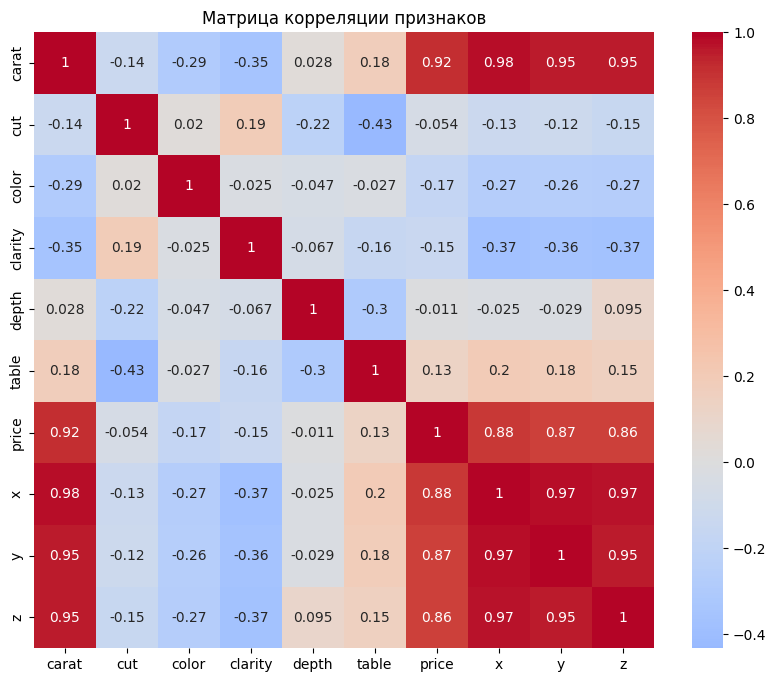

In [ ]:
corr_matrix = df.corr(method='pearson')
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Матрица корреляции признаков")
plt.show()

Для отбора наиболее значимых признаков была проанализирована абсолютная величина корреляции каждого признака с целевой переменной price. Использование модуля позволяет оценить силу линейной связи, игнорируя её направление (положительная или отрицательная), что особенно уместно при ранжировании признаков по «влиятельности». Результат отсортирован по возрастанию, чтобы наглядно выделить признаки с наименьшей и наибольшей корреляцией.
На основе этой оценки и предметной области был сформирован окончательный список признаков features, включённых в дальнейший анализ. Целевая переменная обозначена как target = ['price'].

In [ ]:
print(corr_matrix[['price']].abs().sort_values(by="price"))

features = ['depth', 'cut', 'table',  'clarity', 'color', 'z', 'y', 'x', 'carat' ]
target   = ['price']

            price
depth    0.010793
cut      0.053748
table    0.127774
clarity  0.146776
color    0.172434
z        0.861090
y        0.865296
x        0.884396
carat    0.921513
price    1.000000


Для визуального исследования взаимосвязей между признаками был построен pairplot. График содержит диаграммы рассеяния для всех пар признаков, включая зависимость от целевой переменной price. Несмотря на большое количество точек, можно заметить, что:

1. Признак carat демонстрирует явную положительную зависимость с ценой — чем больше карат, тем выше цена.
2. Признаки x, y, z коррелируют с carat и поэтому также связаны с ценой.
3. Категориальные признаки (color, clarity, cut) оказывают меньшее влияние — разброс значений цены внутри каждого уровня достаточно велик.
4. Признаки depth и table не показывают чёткой зависимости от цены.

В целом, pairplot подтвердил выводы, сделанные на основе матрицы корреляции, и не выявил существенных нелинейных эффектов, требующих дополнительной обработки.

<Figure size 700x700 with 0 Axes>

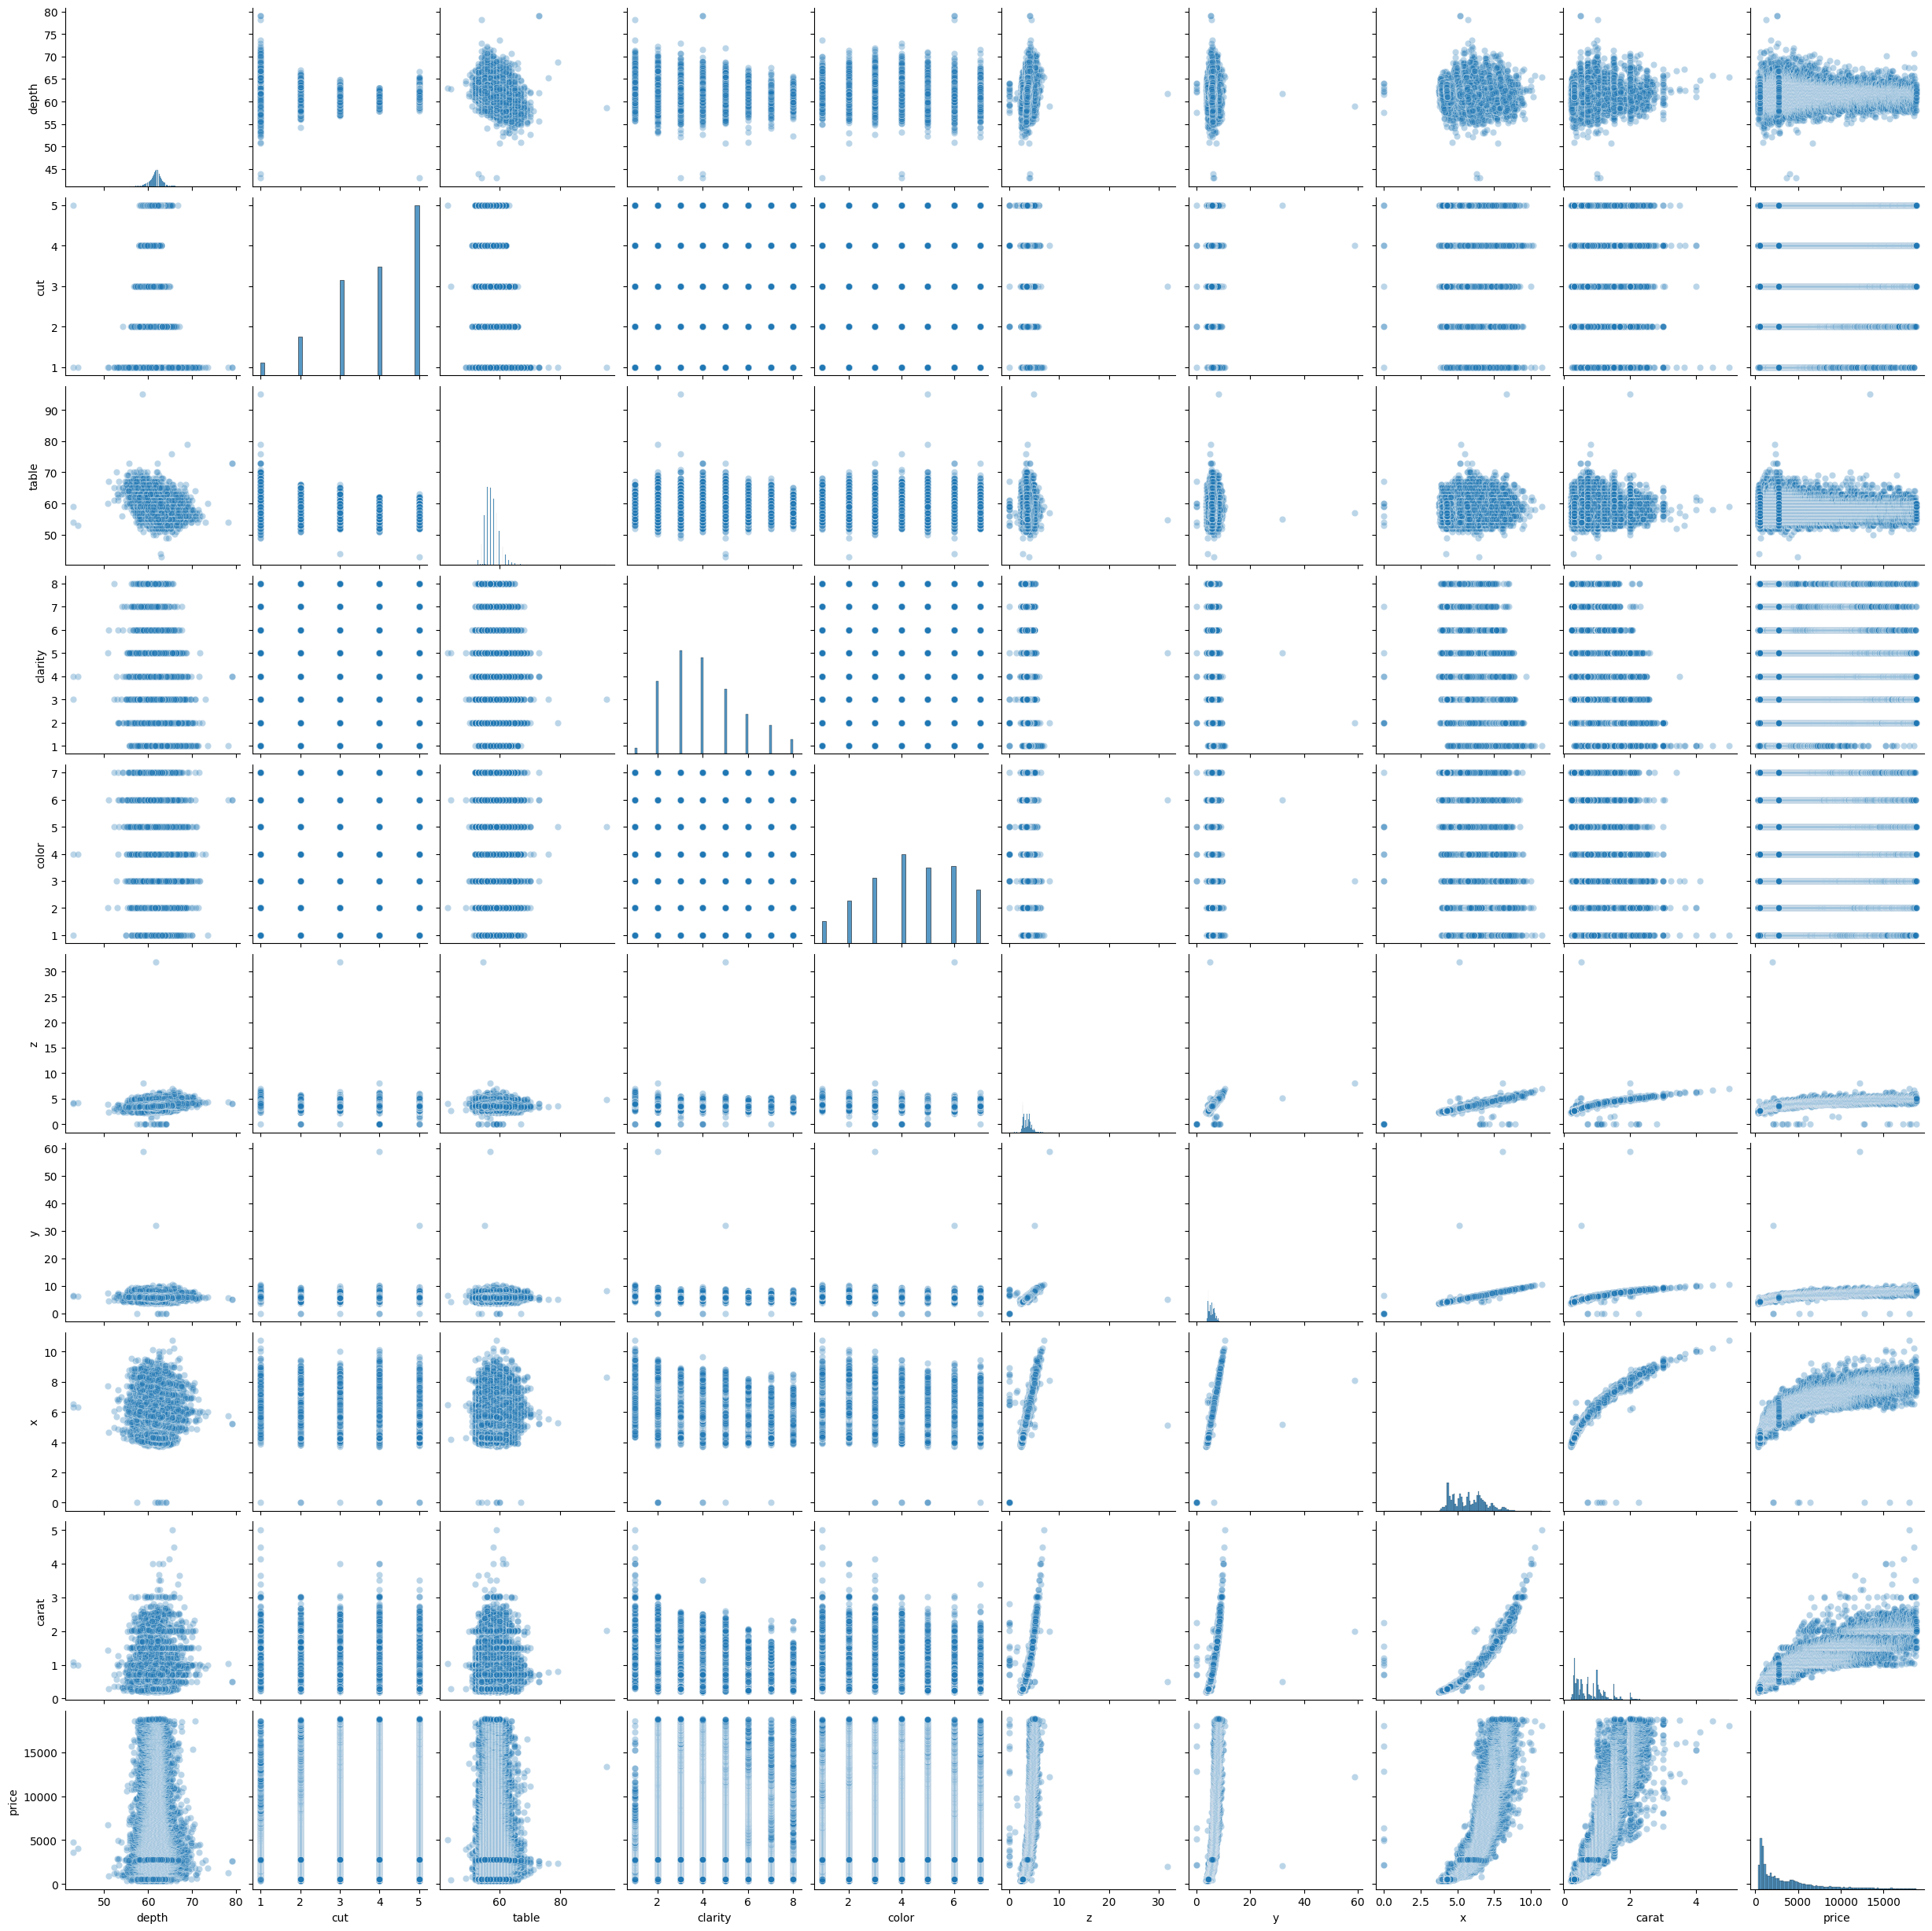

In [ ]:
plt.figure(figsize=(7,7))
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков

sns.pairplot(
    df[features + target],
    kind="scatter",        # Тип диаграмм: reg, scatter
    diag_kind = 'hist',     # Тип диагоральных диаграмм: hist, kde
    plot_kws={'alpha':0.3} # прозрачность точек
);

Для каждого признака из списка (features и target) был построен горизонтальный boxplot, а также рассчитаны границы межквартильного размаха (IQR). Нижняя и верхняя границы выбросов определены по формуле как:

---


lower_bound = Q1 - 1.5 * IQR

upper_bound = Q3 + 1.5 * IQR


---

Фактические «усы» (whiskers) на графике соответствуют минимальному и максимальному значениям в пределах этих границ. Полученные границы сохранены в словаре thresholdDict и могут использоваться позже для фильтрации или обработки выбросов. Тип данных (целый/вещественный) учтён при сохранении значений.

depth: 61.0, 62.5, 58.8, 64.7
cut: 3.0, 5.0, 1, 5
table: 56.0, 59.0, 51.6, 63.5
clarity: 3.0, 5.0, 1, 8
color: 3.0, 6.0, 1, 7
z: 2.91, 4.04, 1.41, 5.73
y: 4.72, 6.54, 3.68, 9.26
x: 4.71, 6.54, 3.73, 9.26
carat: 0.4, 1.04, 0.2, 2.0
price: 950.5, 5328.5, 326.0, 11888.0


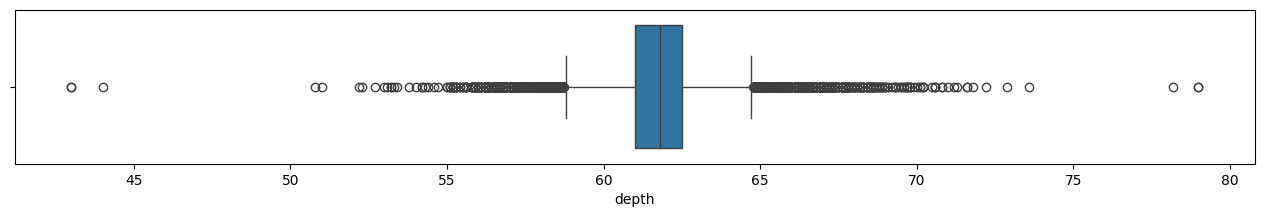

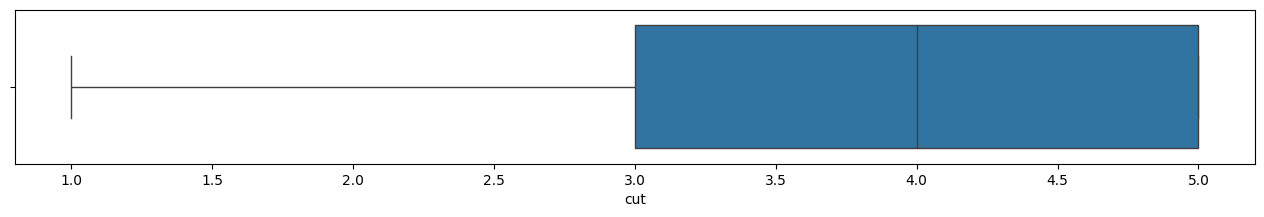

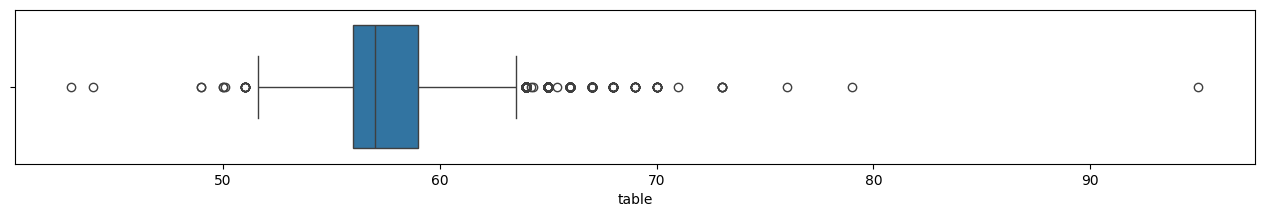

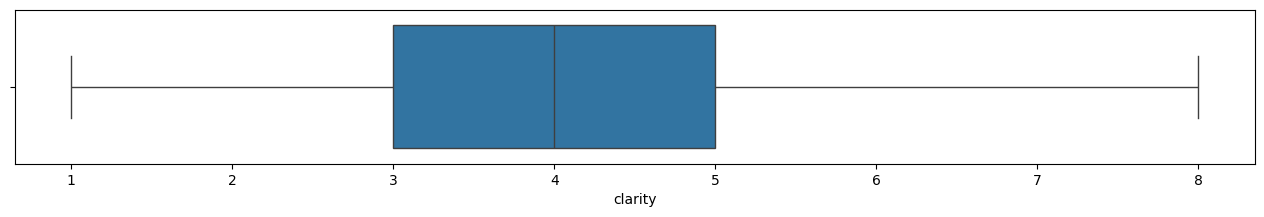

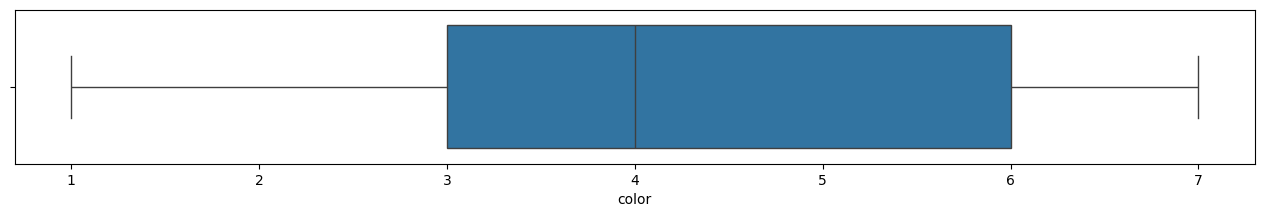

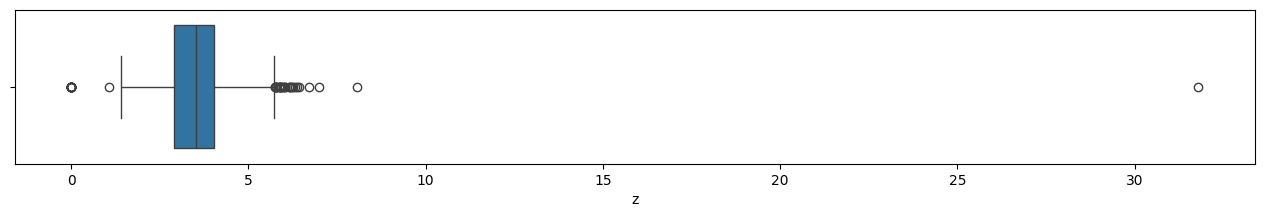

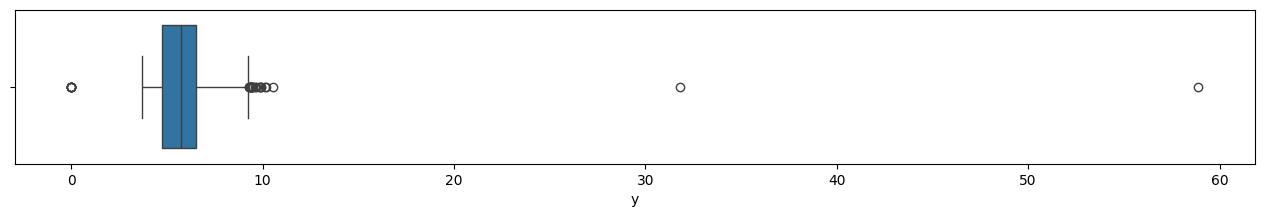

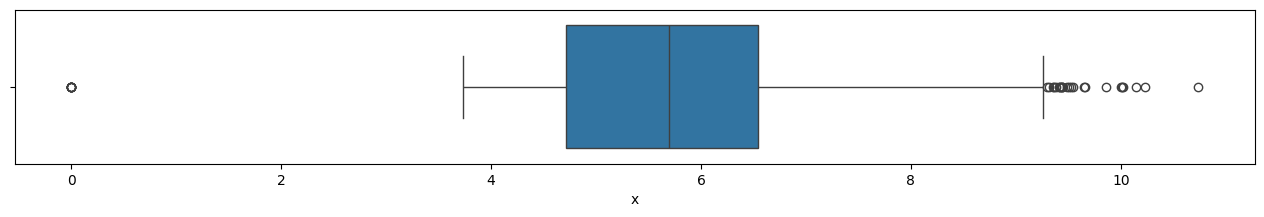

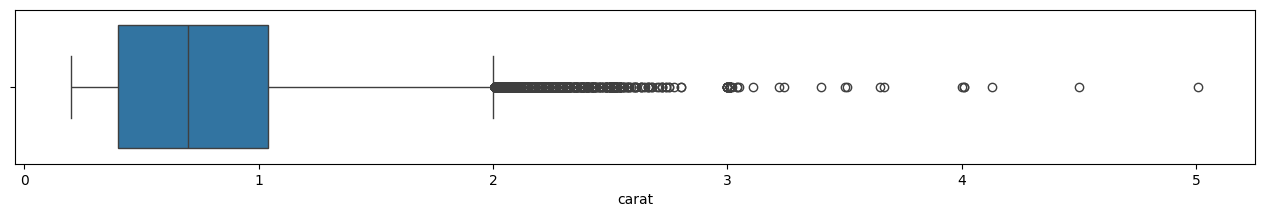

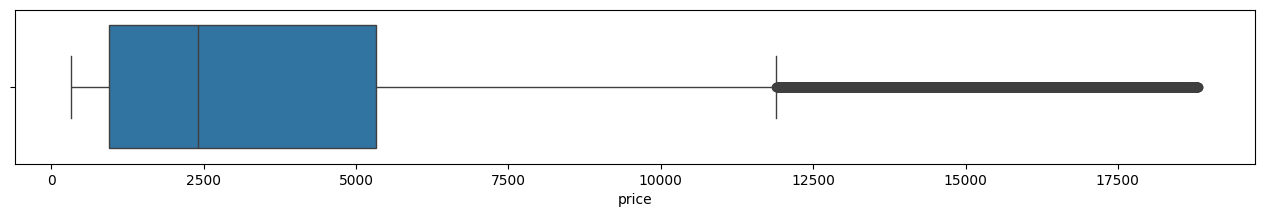

In [ ]:
thresholdDict = {}

for feature_name in (features+target):
  data=df[feature_name]
  plt.figure(figsize=(16,2))
  # На созданном полотне отрисовать boxplot
  sns.boxplot(data=data, orient='h')

  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  lower_whisker = data[data >= lower_bound].min()
  upper_whisker = data[data <= upper_bound].max()

  print(f"{feature_name}: {q1}, {q3}, {lower_whisker}, {upper_whisker}")

  is_int = pd.api.types.is_integer_dtype(df[feature_name].dtype)
  lw = int(lower_whisker) if is_int else float(lower_whisker)
  uw = int(upper_whisker) if is_int else float(upper_whisker)
  thresholdDict[feature_name] = (lw, uw)

Выведен словарь thresholdDict, содержащий рассчитанные границы (нижнюю и верхнюю) для каждого признака на основе метода межквартильного размаха (IQR).

In [ ]:
print (thresholdDict)

{'depth': (58.8, 64.7), 'cut': (1, 5), 'table': (51.6, 63.5), 'clarity': (1, 8), 'color': (1, 7), 'z': (1.41, 5.73), 'y': (3.68, 9.26), 'x': (3.73, 9.26), 'carat': (0.2, 2.0), 'price': (326.0, 11888.0)}


Для каждого признака на основе сохранённых пороговых значений (thresholdDict) подсчитано количество наблюдений, выходящих за пределы диапазона. Приведена абсолютная численность выбросов, общее количество значений и доля выбросов в процентах. Это позволяет оценить, насколько сильно каждый признак «загрязнён» выбросами.

In [ ]:
print(thresholdDict, '\n')
for feature_name  in thresholdDict:
    threshMin =  thresholdDict[feature_name][0] # извлечь нижнее пороговое
    threshMax =  thresholdDict[feature_name][1] # извлечь верхнее пороговое

    # Получить кол-во эл. вне пороговых значений. Прием - фильтрация
    over_count = len(df[~((df[feature_name] >= threshMin) & (df[feature_name] <= threshMax))])

    dcount = df[feature_name].count() # кол-во эл. общее

    print ('''{}. Принимаем пороговые значение равными {}. Кол-во эл. вне пороговых - {} из {} значение(ий) ({:.1%})\n'''.format(
        feature_name,
        thresholdDict[feature_name],
        over_count,
        dcount,
        over_count/ dcount,
    ))

{'depth': (58.8, 64.7), 'cut': (1, 5), 'table': (51.6, 63.5), 'clarity': (1, 8), 'color': (1, 7), 'z': (1.41, 5.73), 'y': (3.68, 9.26), 'x': (3.73, 9.26), 'carat': (0.2, 2.0), 'price': (326.0, 11888.0)} 

depth. Принимаем пороговые значение равными (58.8, 64.7). Кол-во эл. вне пороговых - 2534 из 53711 значение(ий) (4.7%)

cut. Принимаем пороговые значение равными (1, 5). Кол-во эл. вне пороговых - 0 из 53711 значение(ий) (0.0%)

table. Принимаем пороговые значение равными (51.6, 63.5). Кол-во эл. вне пороговых - 600 из 53711 значение(ий) (1.1%)

clarity. Принимаем пороговые значение равными (1, 8). Кол-во эл. вне пороговых - 0 из 53711 значение(ий) (0.0%)

color. Принимаем пороговые значение равными (1, 7). Кол-во эл. вне пороговых - 0 из 53711 значение(ий) (0.0%)

z. Принимаем пороговые значение равными (1.41, 5.73). Кол-во эл. вне пороговых - 49 из 53711 значение(ий) (0.1%)

y. Принимаем пороговые значение равными (3.68, 9.26). Кол-во эл. вне пороговых - 29 из 53711 значение(ий) (0.

На основе рассчитанных пороговых значений (thresholdDict) из датафрейма последовательно удалены все строки, содержащие выбросы хотя бы по одному признаку. Для этого создан новый датафрейм df_filtered как копия исходного, после чего к нему применяется цепочка фильтров по каждому признаку. В результате удалено 6057 строк, что соответствует полной очистке данных от наблюдений, выходящих за границы 1.5 × IQR по любому из признаков.

In [ ]:
df_filtered = df.copy()

for feature_name  in thresholdDict:
    threesMin =  thresholdDict[feature_name][0]
    tresshMax =  thresholdDict[feature_name][1]

    df_filtered = df_filtered[(df_filtered[feature_name] >= threesMin ) & (df_filtered[feature_name] <= tresshMax)]
    print("Обработан ", feature_name )


print ("Отброшено {} строк. Осталось {} строк.".format(
    len(df)  - len(df_filtered),
    len(df_filtered))
)

Обработан  depth
Обработан  cut
Обработан  table
Обработан  clarity
Обработан  color
Обработан  z
Обработан  y
Обработан  x
Обработан  carat
Обработан  price
Отброшено 6384 строк. Осталось 47327 строк.


Построим гистограммы для каждого признака, что бы визуально определить частоту повтора значений признаков (идентифицировать тип распределения каждого признака),  что критически важно для выбора корректных статистических методов и алгоритмов машинного обучения.

depth 58.8 64.7
cut 1 5
table 52.0 63.5
clarity 1 8
color 1 7
z 1.41 5.3
y 3.68 8.27
x 3.73 8.28
carat 0.2 2.0
price 326.0 11888.0


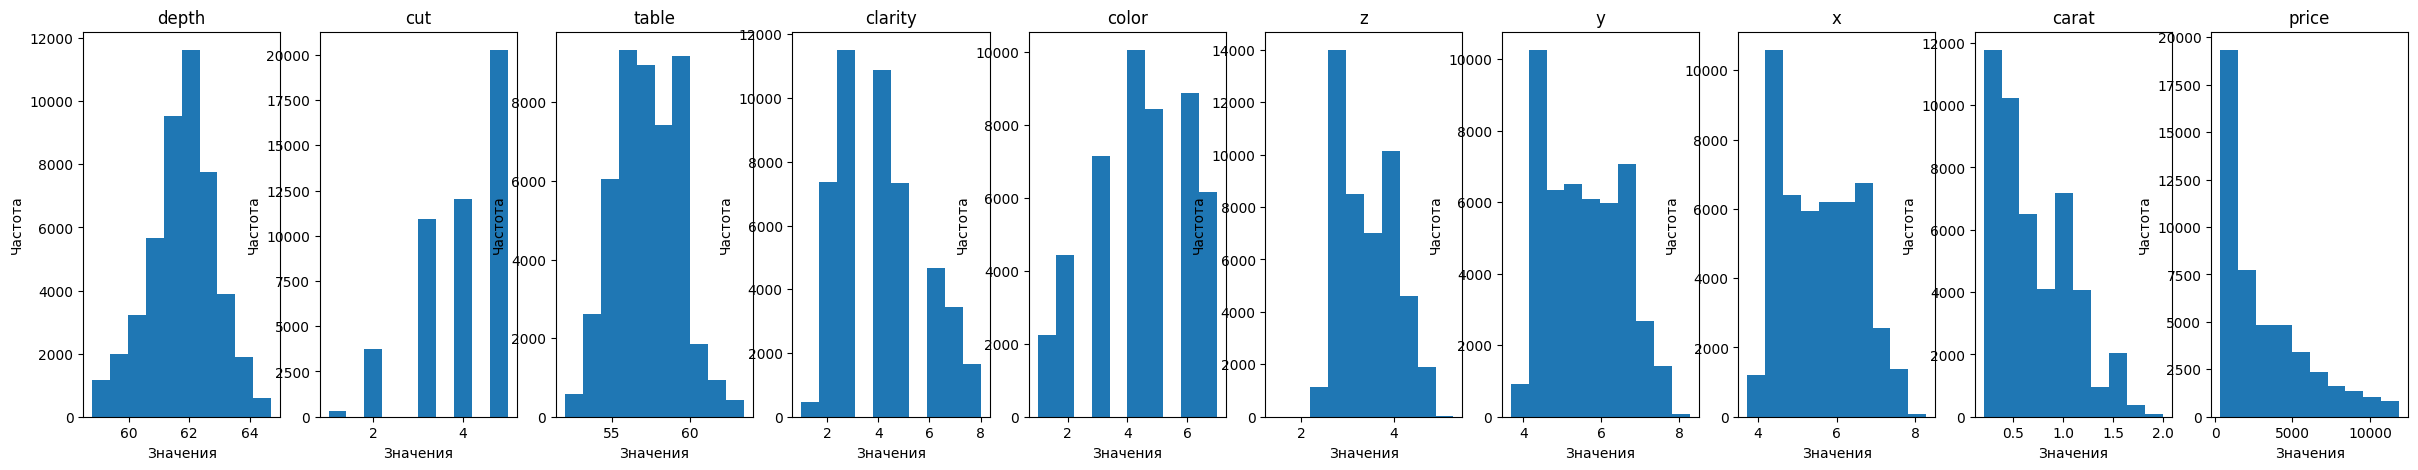

In [ ]:
# Строим гистограммы по каждому признаку:

plt.figure(figsize=(30, 5))
plot_number = 0

for feature_name in (features+target):
    plot_number += 1

    plt.subplot(1, len(features+target), plot_number)

    plt.hist(df_filtered[feature_name]) # Построение гистрограммы

    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')
    print (feature_name, df_filtered[feature_name].min(), df_filtered[feature_name].max())

    '''
    Через визуализацию распределения мы можем идентифицировать тип распределения каждого признака — нормальное, равномерное, экспоненциальное или бимодальное,
    что критически важно для выбора корректных статистических методов и алгоритмов машинного обучения, многие из которых предполагают нормальное распределение данных.
    '''

Сохранение предобработанных данных в отдельный файл фиксирует текущее состояние датасета после завершения этапа очистки и фильтрации, создавая стабильную основу для всех последующих экспериментов с моделью.

In [ ]:
df_filtered.to_csv(
            './df_diamond.csv', # путь для сохранения
            index=False, # запрет сохранения "индексов" (тек. номеров строк)
           )

Данные были разделены на обучающую и тестовую выборки в соотношении 70:30 (test_size = 0.3) с фиксированным random_state для воспроизводимости результатов. Разделение выполнено после фильтрации выбросов, поэтому в обеих выборках присутствуют только «чистые» наблюдения. Приведены размеры полученных подвыборок и пример первых трёх строк тестового признакового набора x_test для проверки корректности разбиения.

In [ ]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    df_filtered[features],    # исходные данные X
    df_filtered[target],      # исходные данные y

    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
)

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} \n".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test),
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

print (x_test[:3])

Кол-во элементов: 
  x_train: 33128, y_train 33128 
  x_test:  14199, y_test  14199 
  total x: 47327, total y 47327 

       depth  cut  table  clarity  color     z     y     x  carat
43885   61.5    5   55.0        4      3  3.24  5.28  5.25   0.54
38117   61.8    5   55.0        8      3  2.66  4.30  4.31   0.30
9191    62.0    5   53.6        6      7  3.59  5.80  5.76   0.73


## Результаты анализа полученных регрессионных линейных моделей

Создадим модель линейной регрессии и прогведём обучение, которое заключается в подборе оптимальных параметров уравнения регрессии на основе предоставленных тренировочных данных.

In [ ]:
model = linear_model.LinearRegression()

model.fit(
    x_train,
    y_train
)

LinearRegression()

Построим график рассеяния вычисленных значений Y_pred от проверочных значений Y_test.

Так же определим метки оценки качества модели:
*   MAE - Mean Absolute Error (Средняя абсолютная ошибка), показывает среднюю величину ошибки
*   MSE - Mean Squared Error (Средняя квадратичная ошибка), показывает средний квадрат ошибок
*   RMSE - Root Mean Squared Error (Среднеквадратичная ошибка), показывает типичноре отклонение величины ошибки
*   R² -R-squared (Коэффициент детерминации), показывает на сколько сильно ошибка отличается от среднего значения.

График рассеяния вычисленных значений Y_pred от проверочных значений Y_test, позволяет выявить систематические ошибки предсказаний — если точки образуют криволинейный паттерн, это свидетельствует о нелинейных зависимостях, которые модель не учла.

Выведем функцию математического уравнения обученной модели линейной регрессии в формате, удобном для чтения и интерпретации. Код последовательно формирует строку, представляющую собой полное уравнение регрессии вида y = w₁·x₁ + w₂·x₂ + ... + wₙ·xₙ + b, где отображаются все ключевые параметры модели:

*   x - признаки влияющие на цено образование изделия;
*   w - вес, показывает насколько сильно каждый признак влияет на результат;
*   b - bias, значение функции при отсутвии признаков.

### Разработка 1 модели и её метрик

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def predict(x_tr, y_tr, x_t, y_t):
    model = linear_model.LinearRegression()

    model.fit(
        x_tr,
        y_tr
    )
    # Получить вычисленные (predicted) значения на проверочном наборе
    y_predicted = model.predict(x_t)
    print('y =', end="")
    for i, kN in enumerate (model.coef_[0]):
        print(f"{' ' if i==0 else '+'} {kN:.3f} * x{i} ", end='')
    print(f"+ {model.intercept_[0]:.3f} ")
    print("\n")


    mae = mean_absolute_error(y_t, y_predicted)
    print(f"MAE: {mae:.2f}")
    mse = mean_squared_error(y_t, y_predicted)
    print(f"MSE: {mse:.2f}")
    rmse = mse ** 0.5
    print(f"RMSE: {rmse:.2f}")
    r2 = r2_score(y_t, y_predicted)
    print(f"R²: {r2:.4f}")
    return(y_predicted)
predict(x_train, y_train, x_test, y_test)

y =  38.473 * x0 + 61.708 * x1 + -23.320 * x2 + 375.046 * x3 + 241.859 * x4 + -1725.773 * x5 + 1212.854 * x6 + -1185.280 * x7 + 10474.998 * x8 + -2473.320 


MAE: 559.85
MSE: 635985.94
RMSE: 797.49
R²: 0.9163


array([[1390.58977251],
       [1314.82992456],
       [4572.42297581],
       ...,
       [1235.98241141],
       [ 510.01222634],
       [6860.12650854]])

На диаграмме "Рассеяния квадрата абсолютной ошибки" по оси X откладываются проверочные значения целевой переменной, а по оси Y — квадраты разностей между фактическими и предсказанными значениями, что визуализирует зависимость величины ошибок от масштаба предсказываемой величины. Равномерное облако точек без выраженных трендов свидетельствует о гомоскедастичности — стабильной дисперсии ошибок across всего диапазона данных, что является важным предположением для корректной работы многих статистических моделей.

y =  38.473 * x0 + 61.708 * x1 + -23.320 * x2 + 375.046 * x3 + 241.859 * x4 + -1725.773 * x5 + 1212.854 * x6 + -1185.280 * x7 + 10474.998 * x8 + -2473.320 


MAE: 559.85
MSE: 635985.94
RMSE: 797.49
R²: 0.9163


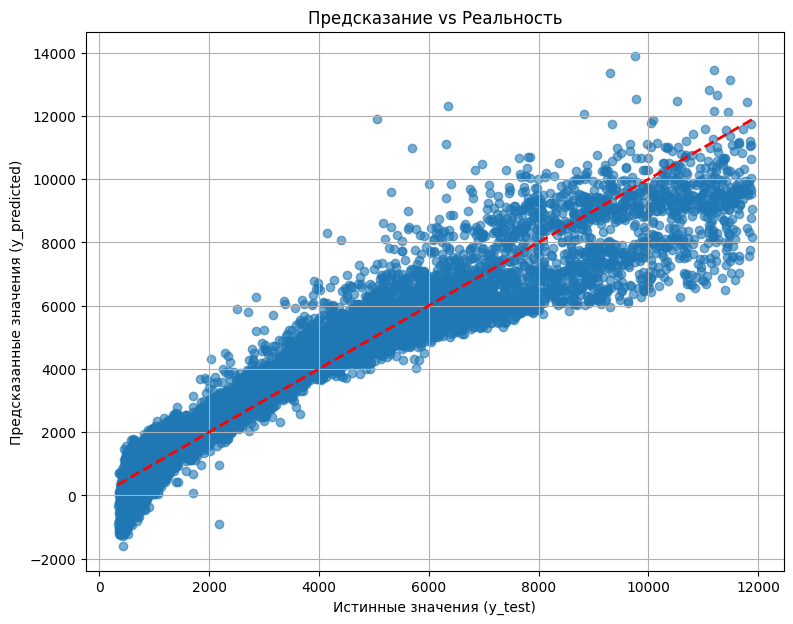

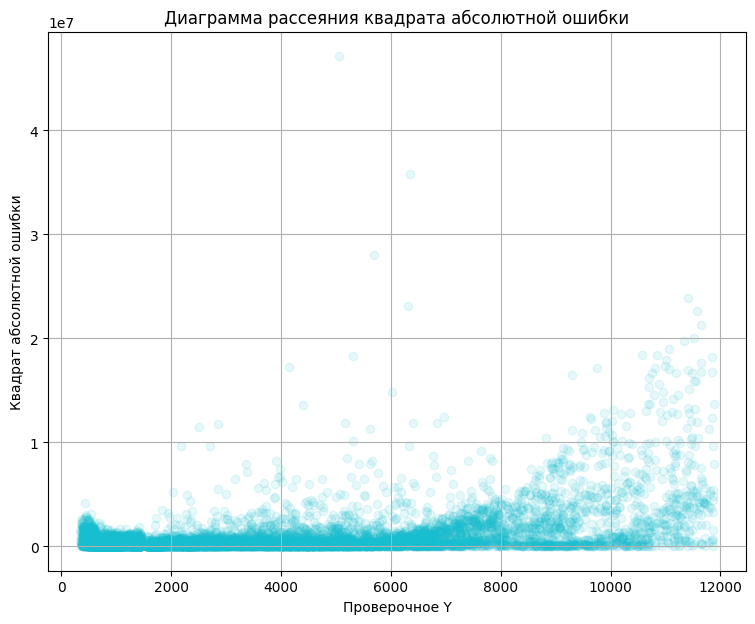

In [ ]:
def PLOT34(y_t, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(9, 7))
    plt.scatter(y_t, y_pred, alpha=0.6)
    plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'r--', lw=2)
    plt.xlabel('Истинные значения (y_test)')
    plt.ylabel('Предсказанные значения (y_predicted)')
    plt.title('Предсказание vs Реальность')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(9, 7))
    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.scatter(y_t, (y_t - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7
    plt.show()
#--------------------------------------------------------------------------

# y_predct = predict(x_train, y_train, x_test, y_test)
PLOT34(
    y_t = y_test,
    y_pred = predict(x_train, y_train, x_test, y_test)
)

Создадим функцию модели ИИ для  построения новой регрессионной модели от набора из нескольких определяющих переменных для дальнейшего сравнения.

### Запустем 2 модель и выведем её метрики

y =  -1961.512 * x0 + 2086.044 * x1 + -2099.388 * x2 + 10054.343 * x3 + 2770.877 


MAE: 635.83
MSE: 1058048.87
RMSE: 1028.62
R²: 0.8607


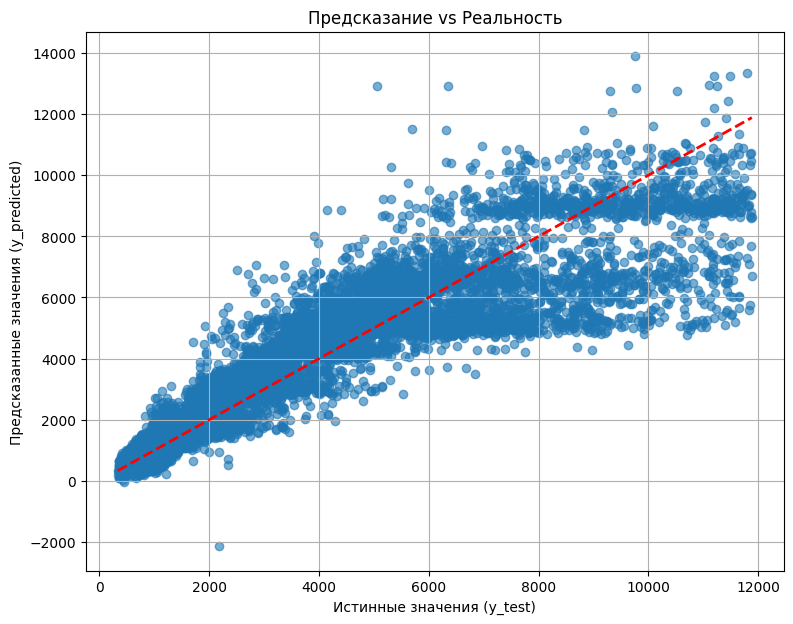

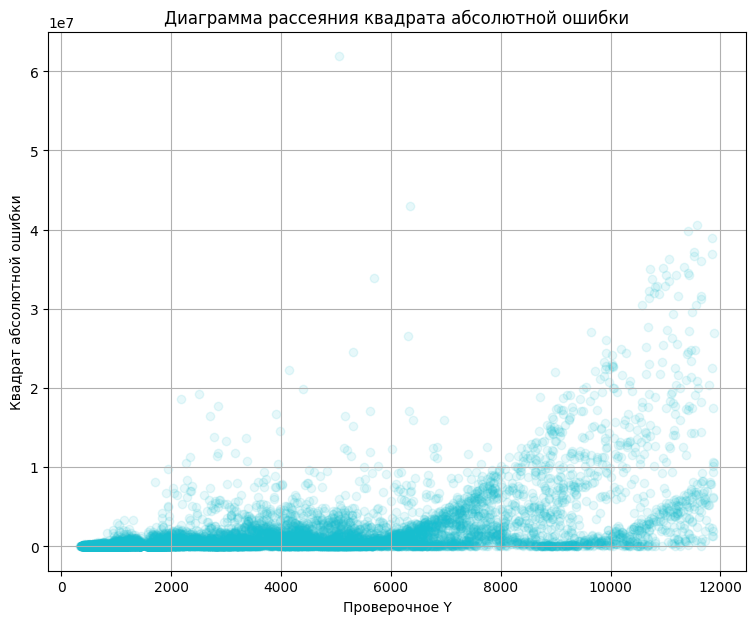

In [ ]:
PLOT34(
    y_t = y_test,
    y_pred = predict(x_train.iloc[:,5:], y_train, x_test.iloc[:,5:], y_test)
)

### Запустем 3 модель и выведем её метрики

y =  62.882 * x0 + 21.320 * x1 + 168.032 * x2 + -225.811 * x3 + -235.423 * x4 + -8495.475 


MAE: 2084.19
MSE: 7169495.88
RMSE: 2677.59
R²: 0.0561


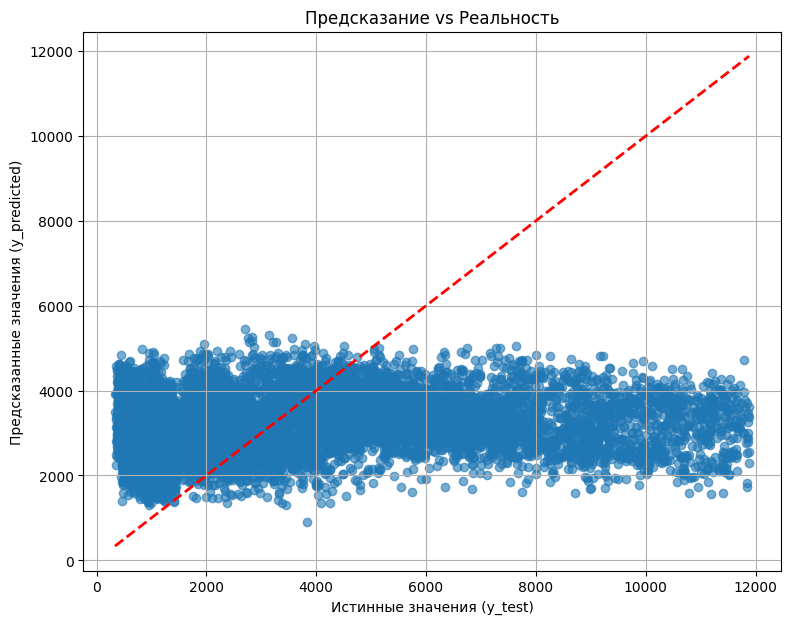

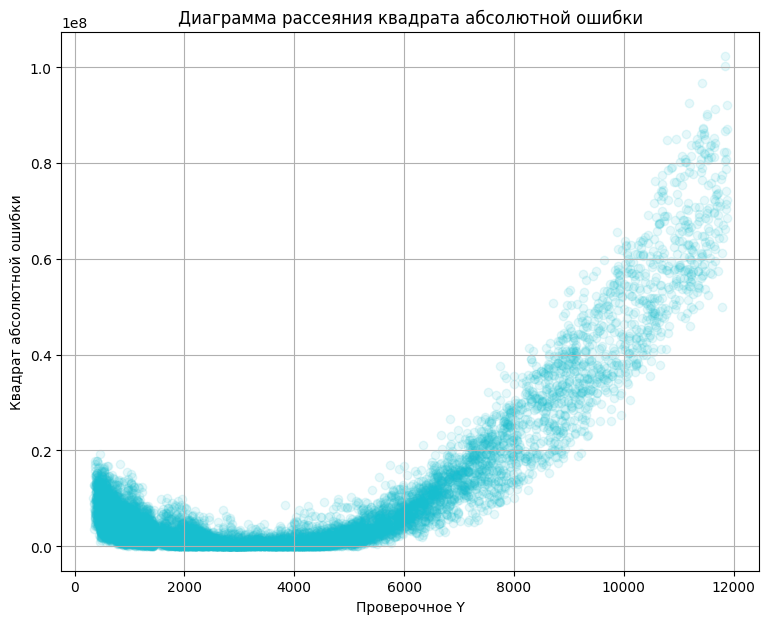

In [ ]:
PLOT34(
    y_t = y_test,
    y_pred = predict(x_train.iloc[:,:5], y_train, x_test.iloc[:,:5], y_test)
)

# Итоги. Сравнение полученных моделей

### Приведем все численные оценки всех моделей для более удобного сравнения:



      M1. Линейная многомерная регрессия. Признаки: ВСЕ.
        Формула линейной регрессии y(x) = 38.473 * x0  +  61.708 * x1  +  -23.320 * x2  +  375.046 * x3  +  241.859 * x4  +  -1725.773 * x5  +  1212.854 * x6  +  -1185.280 * x7  +  10474.998 * x8 + -2473.320
        MAE : 559.85 (средняя абсолютная ошибка)
        MSE : 635985.94 (среднеквадратичная ошибка)
        RMSE: 797.49 (кв. корень из среднеквадратичной ошибки)
        R2  : 0.9163 (коэфф. детерминации)

      M2. Линейная многомерная регрессия. Признаки:  'z', 'y', 'x', 'carat'.
        Формула линейной регрессии y(x) = -1961.512 * x0  +  2086.044 * x1  +  -2099.388 * x2  +  10054.343 * x3 + 2770.877
        MAE : 635.83 (средняя абсолютная ошибка)
        MSE : 1058048.87 (среднеквадратичная ошибка)
        RMSE: 1028.62 (кв. корень из среднеквадратичной ошибки)
        R2  : 0.8607 (коэфф. детерминации)
      
      M3 . Линейная многомерная регрессия. Признаки: 'depth', 'cut', 'table',  'clarity', 'color'.
        Формула линейной регрессии y(x) = 62.882 * x0  +  21.320 * x1  +  168.032 * x2  +  -225.811 * x3  +  -235.423 * x4 + -8495.475
        MAE : 2084.19 (средняя абсолютная ошибка)
        MSE : 7169495.88 (среднеквадратичная ошибка)
        RMSE: 2677.59 (кв. корень из среднеквадратичной ошибки)
        R2  : 0.0561 (коэфф. детерминации)


### Вывод

- Лучшая модель M1 (все признаки): R2 = 0,9163; далее M2:  R2 = 0,8607; худшая M3: R2 = 0,0561.
- Отношения R² к каждой модели:
    1.   R²(M1) / R²(M2) = 1,065;
    2.   R²(M2) / R²(M3) = 15,34;
    3. R²(M1) / R²(M3) = 16,33.
- Наблюдая за 3 моделями можно придти к заключению, что добавленим признаков не в полной мере вляют на точность модели, это можно заметить по метрикам M2 и M3.
- По приведённому выше сравнению можно придти к заключению, что модель М1 являеся более точной, это связано с тем, что оснывными признакоми влияющими на точность прогноза являются carat, x, y, z. В моделе M1 содержатся все 3 признака.




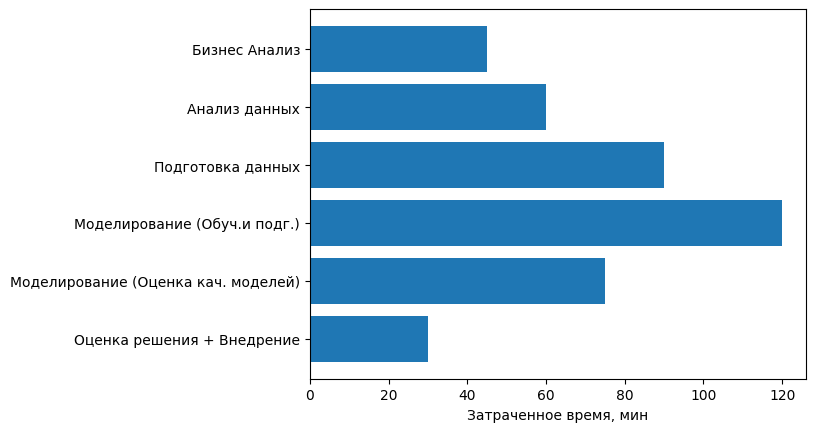

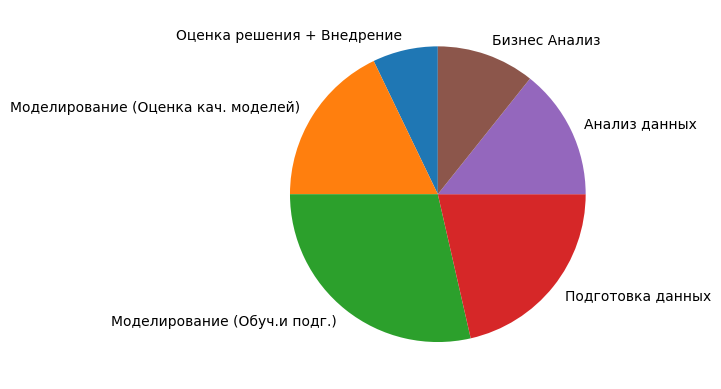

In [ ]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab1 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" :  45 },
  "2": {"step": "Анализ данных",                       "duration, min" :  60 },
  "3": {"step": "Подготовка данных",                   "duration, min" :  90 },
  "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" :  120},
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" :  75 },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" :  30 },
}
, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab1["step"], width= dfSpendTimeLab1["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab1["duration, min"], labels=dfSpendTimeLab1["step"],  startangle = 90 )

plt.show()